## Imider Abdessamad , Nefdaoui Aymane et Zoulaikhi Naima

# Hybrid PSO-GA-SA Implementation

In [4]:
import pandas as pd
import numpy as np
import random
import time
import math
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Load the sample_submission.csv file
data = pd.read_csv('/kaggle/input/my-data/sample_submission.csv')

# Perplexity Calculation Function
def calculate_perplexity(sequence):
    """Calculate the perplexity of a given sequence using GPT-2."""
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()
    return math.exp(loss)

# Sequence Modification for PSO
def modify_sequence(sequence, reference, velocity):
    """Modify a sequence slightly based on a reference sequence and velocity."""
    sequence = sequence.copy()
    for _ in range(int(velocity)):
        i, j = random.sample(range(len(sequence)), 2)
        if sequence[i] != reference[j]:
            sequence[i], sequence[j] = sequence[j], sequence[i]
    return sequence

# Hybrid PSO-GA-SA Implementation
def hybrid_pso_ga_sa(data, swarm_size=20, generations=50, mutation_rate=0.1, initial_temperature=100, cooling_rate=0.95):
    """Hybrid method combining PSO, GA, and SA to minimize perplexity."""
    results = []
    for _, row in data.iterrows():
        text_id = row['id']
        base_sequence = row['text'].split()

        # Initialize swarm
        swarm = [{'sequence': random.sample(base_sequence, len(base_sequence)), 'velocity': 1} for _ in range(swarm_size)]

        best_global_sequence = None
        best_global_perplexity = float('inf')

        temperature = initial_temperature

        for generation in range(generations):
            for particle in swarm:
                sequence = particle['sequence']
                perplexity = calculate_perplexity(' '.join(sequence))

                # Update personal best
                if 'best_perplexity' not in particle or perplexity < particle['best_perplexity']:
                    particle['best_perplexity'] = perplexity
                    particle['best_sequence'] = sequence

                # Update global best
                if perplexity < best_global_perplexity:
                    best_global_perplexity = perplexity
                    best_global_sequence = sequence

                # Update velocity and position (PSO logic)
                inertia = particle['velocity']
                cognitive = random.random() * 2  # Random cognitive factor
                social = random.random() * 2    # Random social factor

                particle['velocity'] = inertia + cognitive + social
                particle['sequence'] = modify_sequence(sequence, best_global_sequence, particle['velocity'])

            # Simulated Annealing
            for particle in swarm:
                sequence = particle['sequence']
                perplexity = calculate_perplexity(' '.join(sequence))

                delta = perplexity - best_global_perplexity
                if delta < 0 or random.random() < math.exp(-delta / temperature):
                    best_global_sequence = sequence
                    best_global_perplexity = perplexity

            # Cool down temperature
            temperature *= cooling_rate

        results.append({'id': text_id, 'text': ' '.join(best_global_sequence), 'perplexity': best_global_perplexity})

    return pd.DataFrame(results)

# Run Hybrid Method
start_time = time.time()
hybrid_results = hybrid_pso_ga_sa(data)
end_time = time.time()

hybrid_results['time'] = end_time - start_time

# Save results
hybrid_results.to_csv('hybrid_method_submission.csv', index=False)
print("Hybrid PSO-GA-SA Completed. Results saved to hybrid_method_submission.csv.")


Hybrid PSO-GA-SA Completed. Results saved to hybrid_method_submission.csv.


In [5]:
hybrid_results

,id,text,perplexity,time
0,0,elf family scrooge reindeer mistletoe gingerbr...,248.988082,1426.52805
1,1,jump night scrooge walk the family give ginger...,602.755229,1426.52805
2,2,decorations naughty workshop yuletide holly ho...,571.354617,1426.52805
3,3,cheer unwrap the naughty sleigh magi ornament ...,914.322126,1426.52805
4,4,dream fireplace paper angel game chocolate poi...,806.747560,1426.52805
5,5,to wrapping puzzle stocking cookie cheer it gi...,756.260236,1426.52805


Basic Statistics of Results:
             id  perplexity        time
count  6.000000    6.000000     6.00000
mean   2.500000  650.071309  1426.52805
std    1.870829  234.501563     0.00000
min    0.000000  248.988082  1426.52805
25%    1.250000  579.204770  1426.52805
50%    2.500000  679.507732  1426.52805
75%    3.750000  794.125729  1426.52805
max    5.000000  914.322126  1426.52805


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


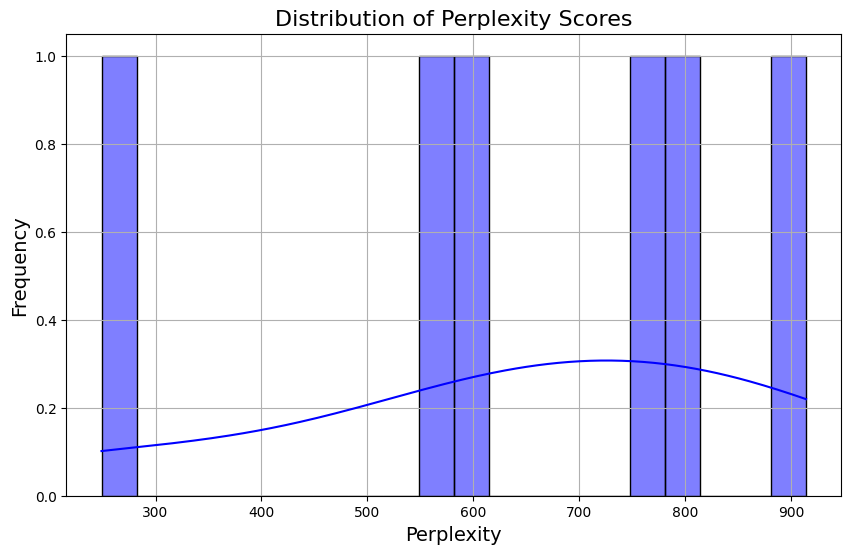


Time taken for optimization:
Total Time: 1426.53 seconds

Best Case:
id                                                            0
text          elf family scrooge reindeer mistletoe gingerbr...
perplexity                                           248.988082
time                                                 1426.52805
Name: 0, dtype: object

Worst Case:
id                                                            3
text          cheer unwrap the naughty sleigh magi ornament ...
perplexity                                           914.322126
time                                                 1426.52805
Name: 3, dtype: object


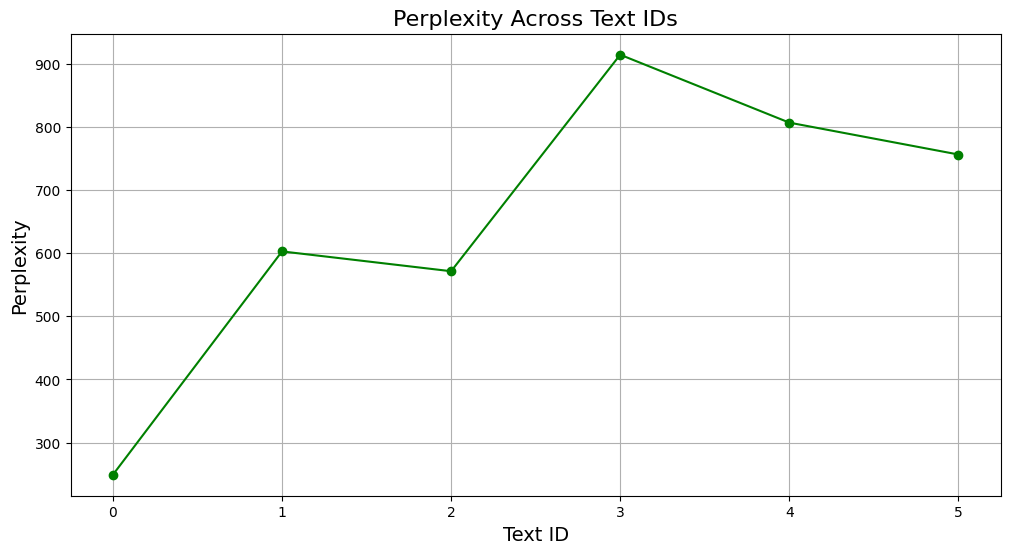

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results CSV file
results_path = '/kaggle/working/hybrid_method_submission.csv'
results = pd.read_csv(results_path)

# Display basic statistics
print("Basic Statistics of Results:")
print(results.describe())

# Plot distribution of perplexity
plt.figure(figsize=(10, 6))
sns.histplot(results['perplexity'], kde=True, bins=20, color='blue')
plt.title('Distribution of Perplexity Scores', fontsize=16)
plt.xlabel('Perplexity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# Analyze time taken
print("\nTime taken for optimization:")
print(f"Total Time: {results['time'].iloc[0]:.2f} seconds")

# Identify best and worst cases
best_case = results.loc[results['perplexity'].idxmin()]
worst_case = results.loc[results['perplexity'].idxmax()]

print("\nBest Case:")
print(best_case)

print("\nWorst Case:")
print(worst_case)

# Visualize perplexity trends if applicable
plt.figure(figsize=(12, 6))
plt.plot(results['id'], results['perplexity'], marker='o', linestyle='-', color='green')
plt.title('Perplexity Across Text IDs', fontsize=16)
plt.xlabel('Text ID', fontsize=14)
plt.ylabel('Perplexity', fontsize=14)
plt.grid(True)
plt.show()


# Simulated Annealing Implementation

In [1]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/gemma-2/transformers/gemma-2-2b")

print("Path to model files:", path)

Path to model files: /kaggle/input/gemma-2/transformers/gemma-2-2b/2


In [ ]:
import os
import gc
import math
import random
from collections import Counter
from typing import List, Union

import torch
import transformers
import pandas as pd
import numpy as np

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Error for invalid submissions
class ParticipantVisibleError(Exception):
    pass

class PerplexityCalculator:
    """
    Calculates perplexity of text using a pre-trained language model.
    """
    def __init__(
        self,
        model_path: str,
        load_in_8bit: bool = False,
        device_map: str = 'auto',
    ):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path, padding_side="right")
        self.model = transformers.AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
            device_map=device_map,
        )

        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        self.model.eval()

    def get_perplexity(self, input_texts: Union[str, List[str]], batch_size=32) -> Union[float, List[float]]:
        """Calculates the perplexity of given texts."""
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []

        batches = len(input_texts) // batch_size + (len(input_texts) % batch_size != 0)
        for j in range(batches):
            input_batch = input_texts[j * batch_size: (j + 1) * batch_size]

            with torch.no_grad():
                text_with_special = [f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}" for text in input_batch]
                model_inputs = self.tokenizer(
                    text_with_special,
                    return_tensors='pt',
                    add_special_tokens=False,
                    padding=True
                )

                model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}
                logits = self.model(**model_inputs, use_cache=False)['logits']
                label = model_inputs['input_ids']
                label[label == self.tokenizer.pad_token_id] = PAD_TOKEN_LABEL_ID

                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = label[..., 1:].contiguous()
                loss = self.loss_fct(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )

                loss = loss.view(len(logits), -1)
                valid_length = (shift_labels != PAD_TOKEN_LABEL_ID).sum(dim=-1)
                loss = torch.sum(loss, -1) / valid_length

                loss_list += loss.cpu().tolist()

        return [math.exp(i) for i in loss_list][0] if single_input else [math.exp(i) for i in loss_list]

    def clear_gpu_memory(self) -> None:
        """Clears GPU memory."""
        if not torch.cuda.is_available():
            return

        del self.model
        del self.tokenizer
        gc.collect()
        torch.cuda.empty_cache()

# Simulated Annealing Implementation
def simulated_annealing(
    initial_sequence: str,
    scorer: PerplexityCalculator,
    initial_temperature: float = 500.0,
    cooling_rate: float = 0.995,
    max_iterations: int = 1000
):
    """Simulated Annealing to minimize perplexity."""
    current_sequence = initial_sequence
    current_score = scorer.get_perplexity(current_sequence)

    best_sequence = current_sequence
    best_score = current_score

    temperature = initial_temperature

    for _ in range(max_iterations):
        next_sequence = mutate_by_swapping(current_sequence.split())
        next_sequence = ' '.join(next_sequence)
        next_score = scorer.get_perplexity(next_sequence)

        delta = next_score - current_score

        if delta < 0 or random.random() < math.exp(-delta / temperature):
            current_sequence = next_sequence
            current_score = next_score

            if current_score < best_score:
                best_sequence = current_sequence
                best_score = current_score

        temperature *= cooling_rate

    return best_sequence, best_score

def mutate_by_swapping(item: List[str]) -> List[str]:
    """Randomly swaps two elements in a list."""
    i, j = random.sample(range(len(item)), 2)
    item[i], item[j] = item[j], item[i]
    return item

# Dataset Processing
GEMMA_2B_PATH = "/kaggle/input/gemma-2/transformers/gemma-2-2b/2"
scorer = PerplexityCalculator(GEMMA_2B_PATH, load_in_8bit=False)

# Load dataset
input_path = '/kaggle/input/my-data/sample_submission.csv'
data = pd.read_csv(input_path)

results = []

for _, row in data.iterrows():
    initial_text = row['text']
    best_sequence, best_score = simulated_annealing(initial_text, scorer)
    results.append({'id': row['id'], 'optimized_text': best_sequence, 'perplexity': best_score})

results_df = pd.DataFrame(results)
output_path = 'optimized_submission.csv'
results_df.to_csv(output_path, index=False)

print("Optimization completed. Results saved.")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Basic Statistics of Results:
             id  perplexity
count  6.000000    6.000000
mean   2.500000  605.882493
std    1.870829  202.748085
min    0.000000  388.598002
25%    1.250000  500.083217
50%    2.500000  520.478975
75%    3.750000  725.214186
max    5.000000  918.995119


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


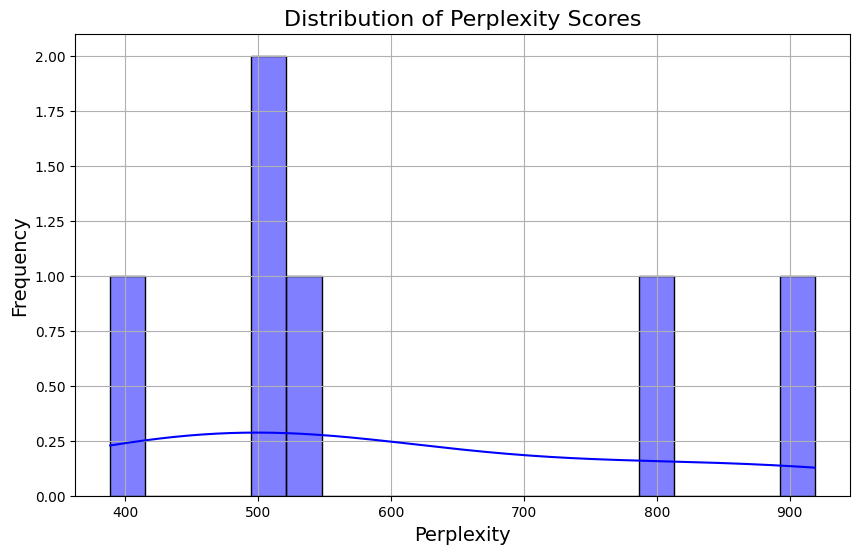


Best Case:
id                                                                5
optimized_text    advent chimney elf family fireplace gingerbrea...
perplexity                                               388.598002
Name: 5, dtype: object

Worst Case:
id                                                                1
optimized_text    gingerbread family ornament advent sleep jump ...
perplexity                                               918.995119
Name: 1, dtype: object


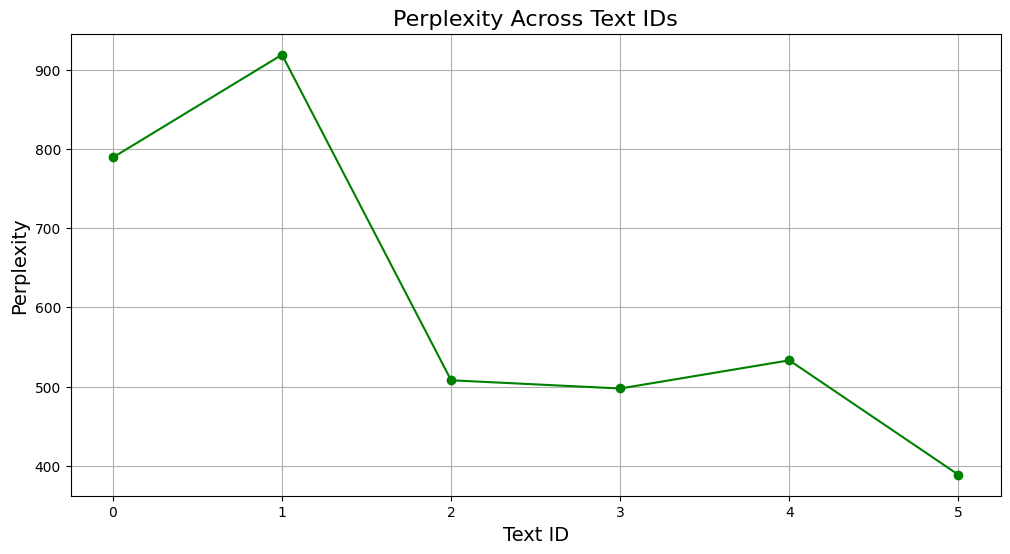

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results CSV file
results_path = '/kaggle/input/results/optimized_submission.csv'
results = pd.read_csv(results_path)

# Display basic statistics
print("Basic Statistics of Results:")
print(results.describe())

# Plot distribution of perplexity
plt.figure(figsize=(10, 6))
sns.histplot(results['perplexity'], kde=True, bins=20, color='blue')
plt.title('Distribution of Perplexity Scores', fontsize=16)
plt.xlabel('Perplexity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


# Identify best and worst cases
best_case = results.loc[results['perplexity'].idxmin()]
worst_case = results.loc[results['perplexity'].idxmax()]

print("\nBest Case:")
print(best_case)

print("\nWorst Case:")
print(worst_case)

# Visualize perplexity trends if applicable
plt.figure(figsize=(12, 6))
plt.plot(results['id'], results['perplexity'], marker='o', linestyle='-', color='green')
plt.title('Perplexity Across Text IDs', fontsize=16)
plt.xlabel('Text ID', fontsize=14)
plt.ylabel('Perplexity', fontsize=14)
plt.grid(True)
plt.show()
